In [1]:
# block 1: imports
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import torch_geometric.transforms as T
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np 

/home/xyx/.conda/envs/ai_lab/lib/python3.10/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.33' not found (required by /home/xyx/.conda/envs/ai_lab/lib/python3.10/site-packages/libpyg.so)
  import torch_geometric.typing
/home/xyx/.conda/envs/ai_lab/lib/python3.10/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.32' not found (required by /home/xyx/.conda/envs/ai_lab/lib/python3.10/site-packages/torch_scatter/_version_cuda.so)
  import torch_geometric.typing
/home/xyx/.conda/envs/ai_lab/lib/python3.10/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.32' not found (requir

In [2]:
# block 2: Load the Cora dataset
dataset = Planetoid(root='/home/xyx/gnn_demo/Cora', name='Cora', transform=T.NormalizeFeatures())

data = dataset[0]

print(f'Dataset: {dataset.name}')
print('==============================================================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of features (Node feature dimension): {dataset.num_node_features}')
print(f'Number of classes (Node labels): {dataset.num_classes}')

print('\n--- Graph Data Object Details ---')
print(f'Node features (data.x shape): {data.x.shape}') 
print(f'Edge index (data.edge_index shape): {data.edge_index.shape}') 
print(f'Node labels (data.y shape): {data.y.shape}') 

print('\n--- Masks ---')
print(f'Train mask sum (Number of training nodes): {data.train_mask.sum().item()}')
print(f'Validation mask sum (Number of validation nodes): {data.val_mask.sum().item()}')
print(f'Test mask sum (Number of test nodes): {data.test_mask.sum().item()}')

Dataset: Cora
Number of graphs: 1
Number of nodes: 2708
Number of edges: 10556
Number of features (Node feature dimension): 1433
Number of classes (Node labels): 7

--- Graph Data Object Details ---
Node features (data.x shape): torch.Size([2708, 1433])
Edge index (data.edge_index shape): torch.Size([2, 10556])
Node labels (data.y shape): torch.Size([2708])

--- Masks ---
Train mask sum (Number of training nodes): 140
Validation mask sum (Number of validation nodes): 500
Test mask sum (Number of test nodes): 1000


In [3]:
# block 3
import torch
import torch.nn.functional as F # Ensure F is imported
import torch.optim as optim     # Ensure optim is imported

class SemiSupervisedAutoencoder(torch.nn.Module):
    def __init__(self, in_dim, embedding_dim, num_classes): # Add num_classes
        super(SemiSupervisedAutoencoder, self).__init__()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(in_dim, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, embedding_dim)
        )
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(embedding_dim, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, in_dim)
        )
        
        # New: Classifier head
        self.classifier = torch.nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        # New: Calculate classification logits
        logits = self.classifier(encoded) 
        return decoded, logits # Return both
        
    def encode(self, x):
        # encode method remains unchanged
        return self.encoder(x)

device = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Reload original dataset and features (ensure we have a clean data object)
dataset = Planetoid(root='/home/xyx/gnn_demo/Cora', name='Cora', transform=T.NormalizeFeatures())
data = dataset[0] # This data object contains original features and labels
original_features = data.x.to(device)
labels = data.y.to(device) # Get labels
train_mask = data.train_mask.to(device) # Get training mask

in_dim = dataset.num_node_features # Should be 1433
embedding_dim = 128 
num_classes = dataset.num_classes # Should be 7

# Instantiate the new Autoencoder
ae_model = SemiSupervisedAutoencoder(in_dim, embedding_dim, num_classes).to(device)

# Define two loss functions
criterion_recon = torch.nn.MSELoss()
criterion_class = torch.nn.CrossEntropyLoss() # Cross-entropy for classification

optimizer_ae = optim.Adam(ae_model.parameters(), lr=0.005, weight_decay=5e-4)

# Define loss weight hyperparameter (needs tuning)
alpha = 1 # Weight for classification loss, can try 0.1, 1.0, 10.0, etc.

print("\n--- Starting Semi-Supervised Autoencoder Training ---")
print(f"Original features shape: {original_features.shape}")
print(f"Embedding shape will be: [ {data.num_nodes}, {embedding_dim} ]")
print(f"Balancing weight (alpha) for classification loss: {alpha}")

num_ae_epochs = 100 # Can try increasing this
ae_model.train()
for epoch in range(1, num_ae_epochs + 1):
    optimizer_ae.zero_grad()
    
    # Get reconstruction results and classification logits
    reconstructed_features, logits = ae_model(original_features)
    
    # 1. Calculate reconstruction loss (on all nodes)
    loss_recon = criterion_recon(reconstructed_features, original_features)
    
    # 2. Calculate classification loss (only on training nodes)
    loss_class = criterion_class(logits[train_mask], labels[train_mask])
    
    # 3. Combine losses with weights
    total_loss = loss_recon + alpha * loss_class
    
    total_loss.backward()
    optimizer_ae.step()
    
    if epoch % 10 == 0:
        # Print both losses for observation
        print(f'Epoch: {epoch:03d}, Total Loss: {total_loss.item():.6f}, '
              f'Recon Loss: {loss_recon.item():.6f}, Class Loss: {loss_class.item():.4f}')

print("--- Semi-Supervised Autoencoder Training Finished ---")

# The way of extracting embeddings remains unchanged
ae_model.eval()
with torch.no_grad():
    new_node_features = ae_model.encode(original_features).detach()

print(f"\nSuccessfully created new node features with shape: {new_node_features.shape}")

# Update the features of the main data object
data.x = new_node_features
data = data.to(device)

print(f"Updated data.x features using Semi-Supervised AE and moved data object to {data.x.device}")

Using device: cuda:7

--- Starting Semi-Supervised Autoencoder Training ---
Original features shape: torch.Size([2708, 1433])
Embedding shape will be: [ 2708, 128 ]
Balancing weight (alpha) for classification loss: 1
Epoch: 010, Total Loss: 1.574374, Recon Loss: 0.000086, Class Loss: 1.5743
Epoch: 020, Total Loss: 0.165537, Recon Loss: 0.000093, Class Loss: 0.1654
Epoch: 030, Total Loss: 0.004520, Recon Loss: 0.000058, Class Loss: 0.0045
Epoch: 040, Total Loss: 0.009693, Recon Loss: 0.000053, Class Loss: 0.0096
Epoch: 050, Total Loss: 0.031040, Recon Loss: 0.000050, Class Loss: 0.0310
Epoch: 060, Total Loss: 0.025234, Recon Loss: 0.000049, Class Loss: 0.0252
Epoch: 070, Total Loss: 0.018975, Recon Loss: 0.000049, Class Loss: 0.0189
Epoch: 080, Total Loss: 0.020843, Recon Loss: 0.000049, Class Loss: 0.0208
Epoch: 090, Total Loss: 0.020046, Recon Loss: 0.000049, Class Loss: 0.0200
Epoch: 100, Total Loss: 0.018500, Recon Loss: 0.000049, Class Loss: 0.0185
--- Semi-Supervised Autoencoder T

In [4]:
# block 4
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        # New: Attribute to store embedding
        self.embedding = None 

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.3, training=self.training) 
        # New: Save embedding after conv1
        self.embedding = x 
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

device = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

in_channels = data.num_node_features # Should be 128
hidden_channels = 16 
out_channels = dataset.num_classes # Should be 7

gcn_model = GCN(in_channels, hidden_channels, out_channels).to(device)

data = data.to(device) 

print("\n--- GCN Model Architecture (2-Layer, Saves Embedding) ---")
print(gcn_model)
print(f"Input features dimension: {in_channels}")
print(f"Embedding dimension (from conv1): {hidden_channels}") # Confirm embedding dimension
print(f"Number of classes: {out_channels}")

Using device: cuda:7

--- GCN Model Architecture (2-Layer, Saves Embedding) ---
GCN(
  (conv1): GCNConv(128, 16)
  (conv2): GCNConv(16, 7)
)
Input features dimension: 128
Embedding dimension (from conv1): 16
Number of classes: 7


In [5]:
# block 5
import torch.optim as optim
import torch.nn.functional as F
import copy # For saving best model state

optimizer_gcn = optim.Adam(gcn_model.parameters(), lr=0.005, weight_decay=5e-4) 

def train():
    gcn_model.train()
    optimizer_gcn.zero_grad()
    out = gcn_model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer_gcn.step()
    return loss.item()

@torch.no_grad()
def test():
    gcn_model.eval()
    out = gcn_model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    train_correct = pred[data.train_mask] == data.y[data.train_mask]
    train_acc = int(train_correct.sum()) / int(data.train_mask.sum())
    val_correct = pred[data.val_mask] == data.y[data.val_mask]
    val_acc = int(val_correct.sum()) / int(data.val_mask.sum())
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return train_acc, val_acc, test_acc

num_epochs = 100 
best_val_acc = 0.0
best_model_state = None

# New: Lists to log accuracy
epochs = []
train_accs = []
val_accs = []
test_accs = []
# End new

print("\n--- Starting GCN Training (using Semi-Supervised AE features) ---")
for epoch in range(1, num_epochs + 1):
    loss = train()
    train_acc, val_acc, test_acc = test()
    
    # New: Log data
    epochs.append(epoch)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)
    # End new
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(gcn_model.state_dict()) 
        
    if epoch % 20 == 0: 
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
              f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

print("--- GCN Training Finished ---")

print(f"\nLoading best GCN model state with Val Acc: {best_val_acc:.4f}")
if best_model_state:
    gcn_model.load_state_dict(best_model_state)
else:
    print("Warning: No best model state was saved.")

final_train_acc, final_val_acc, final_test_acc = test()
print("\n--- Final GCN Evaluation (Best Model) ---")
print(f'Final Training Accuracy: {final_train_acc:.4f}')
print(f'Final Validation Accuracy (Best): {final_val_acc:.4f}')
print(f'Final Test Accuracy: {final_test_acc:.4f}')

print("\nAccuracy history lists (train_accs, val_accs, test_accs) are populated.")


--- Starting GCN Training (using Semi-Supervised AE features) ---
Epoch: 020, Loss: 1.0335, Train Acc: 0.8929, Val Acc: 0.6600, Test Acc: 0.6940
Epoch: 040, Loss: 0.4763, Train Acc: 0.9786, Val Acc: 0.7140, Test Acc: 0.7430
Epoch: 060, Loss: 0.2484, Train Acc: 0.9857, Val Acc: 0.7400, Test Acc: 0.7710
Epoch: 080, Loss: 0.1702, Train Acc: 0.9929, Val Acc: 0.7500, Test Acc: 0.7730
Epoch: 100, Loss: 0.1632, Train Acc: 0.9929, Val Acc: 0.7460, Test Acc: 0.7780
--- GCN Training Finished ---

Loading best GCN model state with Val Acc: 0.7560

--- Final GCN Evaluation (Best Model) ---
Final Training Accuracy: 0.9929
Final Validation Accuracy (Best): 0.7560
Final Test Accuracy: 0.7760

Accuracy history lists (train_accs, val_accs, test_accs) are populated.


In [6]:
# block 6
import torch
import torch.nn.functional as F
import torch.optim as optim

# --- Define Pure Autoencoder Class ---
class PureAutoencoder(torch.nn.Module):
    def __init__(self, in_dim, embedding_dim):
        super(PureAutoencoder, self).__init__()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(in_dim, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, embedding_dim)
        )
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(embedding_dim, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, in_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded # Only return reconstructed result
        
    def encode(self, x):
        return self.encoder(x)
# --- End of definition ---

device = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Reload original dataset and features (ensure we have a clean data object)
dataset_pure = Planetoid(root='/home/xyx/gnn_demo/Cora', name='Cora', transform=T.NormalizeFeatures())
data_pure = dataset_pure[0] # Use a new data object data_pure
original_features_pure = data_pure.x.to(device)

in_dim_pure = dataset_pure.num_node_features # Should be 1433
embedding_dim_pure = 128 

# Instantiate *Pure* Autoencoder
ae_model_pure = PureAutoencoder(in_dim_pure, embedding_dim_pure).to(device)

# Define *pure* reconstruction loss
criterion_recon_pure = torch.nn.MSELoss()

optimizer_ae_pure = optim.Adam(ae_model_pure.parameters(), lr=0.005, weight_decay=5e-4)

print("\n--- Starting PURE Autoencoder Training ---")
print(f"Original features shape: {original_features_pure.shape}")
print(f"New embedding shape will be: [ {data_pure.num_nodes}, {embedding_dim_pure} ]")

num_ae_epochs_pure = 100 
ae_model_pure.train()
for epoch in range(1, num_ae_epochs_pure + 1):
    optimizer_ae_pure.zero_grad()
    
    reconstructed_features_pure = ae_model_pure(original_features_pure)
    
    # Only calculate reconstruction loss
    loss_recon_pure = criterion_recon_pure(reconstructed_features_pure, original_features_pure)
    
    loss_recon_pure.backward()
    optimizer_ae_pure.step()
    
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Reconstruction Loss: {loss_recon_pure.item():.6f}')

print("--- PURE Autoencoder Training Finished ---")

# Extract embeddings
ae_model_pure.eval()
with torch.no_grad():
    new_node_features_pure = ae_model_pure.encode(original_features_pure).detach()

print(f"\nSuccessfully created new node features (pure AE) with shape: {new_node_features_pure.shape}")

# Update features of data_pure object, *not* overwriting the previous data object
data_pure.x = new_node_features_pure
data_pure = data_pure.to(device)

print(f"Updated data_pure.x features using PURE AE and moved data_pure object to {data_pure.x.device}")

Using device: cuda:7

--- Starting PURE Autoencoder Training ---
Original features shape: torch.Size([2708, 1433])
New embedding shape will be: [ 2708, 128 ]
Epoch: 010, Reconstruction Loss: 0.000087
Epoch: 020, Reconstruction Loss: 0.000091
Epoch: 030, Reconstruction Loss: 0.000059
Epoch: 040, Reconstruction Loss: 0.000054
Epoch: 050, Reconstruction Loss: 0.000050
Epoch: 060, Reconstruction Loss: 0.000049
Epoch: 070, Reconstruction Loss: 0.000049
Epoch: 080, Reconstruction Loss: 0.000049
Epoch: 090, Reconstruction Loss: 0.000049
Epoch: 100, Reconstruction Loss: 0.000049
--- PURE Autoencoder Training Finished ---

Successfully created new node features (pure AE) with shape: torch.Size([2708, 128])
Updated data_pure.x features using PURE AE and moved data_pure object to cuda:7


In [7]:
# block 7
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# --- Use 2-Layer GCN class that includes embedding saving ---
# (This class definition is now the same as in Block 4)
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        # --- This line is needed for initialization ---
        self.embedding = None 

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.3, training=self.training) 
        # --- This line is needed to save the embedding ---
        self.embedding = x 
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)
# --- End of GCN Class Definition ---

device = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Use features from the data_pure object
in_channels_pure = data_pure.num_node_features # Should be 128
hidden_channels_pure = 16 
out_channels_pure = dataset_pure.num_classes # Should be 7

# Instantiate *new* GCN model (this class now saves embeddings)
gcn_model_pure = GCN(in_channels_pure, hidden_channels_pure, out_channels_pure).to(device)

# Ensure data_pure object is on the device
data_pure = data_pure.to(device) 

print("\n--- GCN Model Architecture (for Pure AE features, Saves Embedding) ---")
print(gcn_model_pure)
print(f"Input features dimension: {in_channels_pure}")
print(f"Embedding dimension (from conv1): {hidden_channels_pure}") # Confirm embedding dimension
print(f"Number of classes: {out_channels_pure}")

Using device: cuda:7

--- GCN Model Architecture (for Pure AE features, Saves Embedding) ---
GCN(
  (conv1): GCNConv(128, 16)
  (conv2): GCNConv(16, 7)
)
Input features dimension: 128
Embedding dimension (from conv1): 16
Number of classes: 7


In [8]:
# block 8
import torch.optim as optim
import torch.nn.functional as F
import copy # For saving best model state

optimizer_gcn_pure = optim.Adam(gcn_model_pure.parameters(), lr=0.005, weight_decay=5e-4) 

def train_pure():
    gcn_model_pure.train()
    optimizer_gcn_pure.zero_grad()
    out = gcn_model_pure(data_pure.x, data_pure.edge_index) 
    loss = F.nll_loss(out[data_pure.train_mask], data_pure.y[data_pure.train_mask]) 
    loss.backward()
    optimizer_gcn_pure.step()
    return loss.item()

@torch.no_grad()
def test_pure():
    gcn_model_pure.eval()
    out = gcn_model_pure(data_pure.x, data_pure.edge_index) 
    pred = out.argmax(dim=1)
    train_correct = pred[data_pure.train_mask] == data_pure.y[data_pure.train_mask]
    train_acc = int(train_correct.sum()) / int(data_pure.train_mask.sum())
    val_correct = pred[data_pure.val_mask] == data_pure.y[data_pure.val_mask]
    val_acc = int(val_correct.sum()) / int(data_pure.val_mask.sum())
    test_correct = pred[data_pure.test_mask] == data_pure.y[data_pure.test_mask]
    test_acc = int(test_correct.sum()) / int(data_pure.test_mask.sum())
    return train_acc, val_acc, test_acc

num_epochs_pure = 100 
best_val_acc_pure = 0.0
best_model_state_pure = None

# New: Lists to log accuracy (using _pure suffix)
epochs_pure = []
train_accs_pure = []
val_accs_pure = []
test_accs_pure = []
# End new

print("\n--- Starting GCN Training (using PURE AE features) ---")
for epoch in range(1, num_epochs_pure + 1):
    loss_pure = train_pure()
    train_acc_pure, val_acc_pure, test_acc_pure = test_pure()
    
    # New: Log data
    epochs_pure.append(epoch)
    train_accs_pure.append(train_acc_pure)
    val_accs_pure.append(val_acc_pure)
    test_accs_pure.append(test_acc_pure)
    # End new
    
    if val_acc_pure > best_val_acc_pure:
        best_val_acc_pure = val_acc_pure
        best_model_state_pure = copy.deepcopy(gcn_model_pure.state_dict()) 
        
    if epoch % 20 == 0: 
        print(f'Epoch: {epoch:03d}, Loss: {loss_pure:.4f}, '
              f'Train Acc: {train_acc_pure:.4f}, Val Acc: {val_acc_pure:.4f}, Test Acc: {test_acc_pure:.4f}')

print("--- GCN Training (Pure AE) Finished ---")

print(f"\nLoading best GCN model state (Pure AE) with Val Acc: {best_val_acc_pure:.4f}")
if best_model_state_pure:
    gcn_model_pure.load_state_dict(best_model_state_pure)
else:
    print("Warning: No best model state (Pure AE) was saved.")

final_train_acc_pure, final_val_acc_pure, final_test_acc_pure = test_pure()
print("\n--- Final GCN Evaluation (Best Model - Pure AE features) ---")
print(f'Final Training Accuracy: {final_train_acc_pure:.4f}')
print(f'Final Validation Accuracy (Best): {final_val_acc_pure:.4f}')
print(f'Final Test Accuracy: {final_test_acc_pure:.4f}')

print("\nAccuracy history lists (train_accs_pure, val_accs_pure, test_accs_pure) are populated.")


--- Starting GCN Training (using PURE AE features) ---
Epoch: 020, Loss: 1.9414, Train Acc: 0.1286, Val Acc: 0.1240, Test Acc: 0.1120
Epoch: 040, Loss: 1.9351, Train Acc: 0.1571, Val Acc: 0.1120, Test Acc: 0.1050
Epoch: 060, Loss: 1.9328, Train Acc: 0.1571, Val Acc: 0.1260, Test Acc: 0.1220
Epoch: 080, Loss: 1.9208, Train Acc: 0.1571, Val Acc: 0.1200, Test Acc: 0.1230
Epoch: 100, Loss: 1.9187, Train Acc: 0.1571, Val Acc: 0.1460, Test Acc: 0.1270
--- GCN Training (Pure AE) Finished ---

Loading best GCN model state (Pure AE) with Val Acc: 0.1700

--- Final GCN Evaluation (Best Model - Pure AE features) ---
Final Training Accuracy: 0.1571
Final Validation Accuracy (Best): 0.1700
Final Test Accuracy: 0.1730

Accuracy history lists (train_accs_pure, val_accs_pure, test_accs_pure) are populated.


In [9]:
# block 9
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid # Re-import to load original data
import torch_geometric.transforms as T      # Re-import Transform

# --- Use 2-Layer GCN class that includes embedding saving ---
# (This class definition is the same as in Block 4 / Block 7)
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.embedding = None 

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.3, training=self.training) # Keep dropout consistent with previous blocks
        self.embedding = x 
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)
# --- End of GCN Class Definition ---

device = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# --- Load original Cora data (No AE) ---
print("Loading original Cora data...")
dataset_orig = Planetoid(root='/home/xyx/gnn_demo/Cora', name='Cora', transform=T.NormalizeFeatures())
data_orig = dataset_orig[0] # Use new data object data_orig
# --- End loading ---

# Use original feature dimension from data_orig object
in_channels_orig = data_orig.num_node_features # Should be 1433
hidden_channels_orig = 16 # Keep hidden layer dimension consistent
out_channels_orig = dataset_orig.num_classes # Should be 7

# Instantiate *new* GCN model (using _orig suffix)
gcn_model_orig = GCN(in_channels_orig, hidden_channels_orig, out_channels_orig).to(device)

# Move data_orig object to device
data_orig = data_orig.to(device) 

print("\n--- GCN Model Architecture (for Original features) ---")
print(gcn_model_orig)
print(f"Input features dimension: {in_channels_orig}")
print(f"Embedding dimension (from conv1): {hidden_channels_orig}")
print(f"Number of classes: {out_channels_orig}")
print(f"Data object 'data_orig' is on device: {data_orig.x.device}")

Using device: cuda:7
Loading original Cora data...

--- GCN Model Architecture (for Original features) ---
GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)
Input features dimension: 1433
Embedding dimension (from conv1): 16
Number of classes: 7
Data object 'data_orig' is on device: cuda:7


In [10]:
# block 10
import torch.optim as optim
import torch.nn.functional as F
import copy # For saving best model state

# Use *new* optimizer (with _orig suffix)
optimizer_gcn_orig = optim.Adam(gcn_model_orig.parameters(), lr=0.005, weight_decay=5e-4) # Use the same learning rate and decay

# Define *new* train and test functions (with _orig suffix)

def train_orig():
    gcn_model_orig.train()
    optimizer_gcn_orig.zero_grad()
    # Use data_orig object
    out = gcn_model_orig(data_orig.x, data_orig.edge_index) 
    # Use data_orig masks and labels
    loss = F.nll_loss(out[data_orig.train_mask], data_orig.y[data_orig.train_mask]) 
    loss.backward()
    optimizer_gcn_orig.step()
    return loss.item()

@torch.no_grad()
def test_orig():
    gcn_model_orig.eval()
    # Use data_orig object
    out = gcn_model_orig(data_orig.x, data_orig.edge_index) 
    pred = out.argmax(dim=1)
    
    # Use data_orig masks and labels
    train_correct = pred[data_orig.train_mask] == data_orig.y[data_orig.train_mask]
    train_acc = int(train_correct.sum()) / int(data_orig.train_mask.sum())
    
    val_correct = pred[data_orig.val_mask] == data_orig.y[data_orig.val_mask]
    val_acc = int(val_correct.sum()) / int(data_orig.val_mask.sum())
    
    test_correct = pred[data_orig.test_mask] == data_orig.y[data_orig.test_mask]
    test_acc = int(test_correct.sum()) / int(data_orig.test_mask.sum())
    
    return train_acc, val_acc, test_acc

# Use *new* variables to track best state and log accuracy (with _orig suffix)
num_epochs_orig = 100 # GCN usually converges faster on original features
best_val_acc_orig = 0.0
best_model_state_orig = None
epochs_orig = []
train_accs_orig = []
val_accs_orig = []
test_accs_orig = [] # Log test accuracy (optional)

print("\n--- Starting GCN Training (using ORIGINAL Cora features) ---")
for epoch in range(1, num_epochs_orig + 1):
    loss_orig = train_orig()
    train_acc_orig, val_acc_orig, test_acc_orig = test_orig()
    
    # Log data
    epochs_orig.append(epoch)
    train_accs_orig.append(train_acc_orig)
    val_accs_orig.append(val_acc_orig)
    test_accs_orig.append(test_acc_orig) # Log test accuracy
    
    # Early stopping logic
    if val_acc_orig > best_val_acc_orig:
        best_val_acc_orig = val_acc_orig
        best_model_state_orig = copy.deepcopy(gcn_model_orig.state_dict()) 
        
    if epoch % 20 == 0: 
        print(f'Epoch: {epoch:03d}, Loss: {loss_orig:.4f}, '
              f'Train Acc: {train_acc_orig:.4f}, Val Acc: {val_acc_orig:.4f}, Test Acc: {test_acc_orig:.4f}')

print("--- GCN Training (Original Features) Finished ---")

print(f"\nLoading best GCN model state (Original Features) with Val Acc: {best_val_acc_orig:.4f}")
if best_model_state_orig:
    gcn_model_orig.load_state_dict(best_model_state_orig)
else:
    print("Warning: No best model state (Original Features) was saved.")

final_train_acc_orig, final_val_acc_orig, final_test_acc_orig = test_orig()
print("\n--- Final GCN Evaluation (Best Model - Original Features) ---")
print(f'Final Training Accuracy: {final_train_acc_orig:.4f}')
print(f'Final Validation Accuracy (Best): {final_val_acc_orig:.4f}')
print(f'Final Test Accuracy: {final_test_acc_orig:.4f}')

print("\nAccuracy history lists (train_accs_orig, val_accs_orig, test_accs_orig) are populated.")


--- Starting GCN Training (using ORIGINAL Cora features) ---
Epoch: 020, Loss: 1.8408, Train Acc: 0.8286, Val Acc: 0.5460, Test Acc: 0.5490
Epoch: 040, Loss: 1.6513, Train Acc: 0.9071, Val Acc: 0.6380, Test Acc: 0.6330
Epoch: 060, Loss: 1.4500, Train Acc: 0.9357, Val Acc: 0.7080, Test Acc: 0.7150
Epoch: 080, Loss: 1.1839, Train Acc: 0.9643, Val Acc: 0.7420, Test Acc: 0.7570
Epoch: 100, Loss: 0.9513, Train Acc: 0.9714, Val Acc: 0.7560, Test Acc: 0.7860
--- GCN Training (Original Features) Finished ---

Loading best GCN model state (Original Features) with Val Acc: 0.7580

--- Final GCN Evaluation (Best Model - Original Features) ---
Final Training Accuracy: 0.9714
Final Validation Accuracy (Best): 0.7580
Final Test Accuracy: 0.7840

Accuracy history lists (train_accs_orig, val_accs_orig, test_accs_orig) are populated.


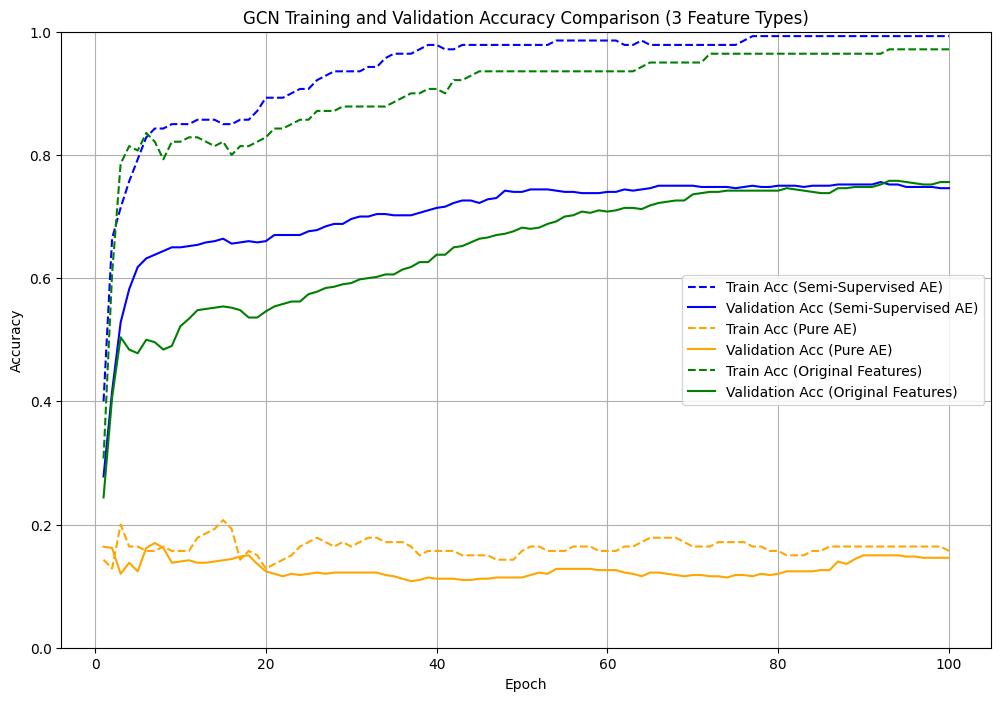


--- Starting t-SNE Visualization (Semi-Supervised AE Features) ---
Embeddings shape: (2708, 16)
t-SNE fitting finished.


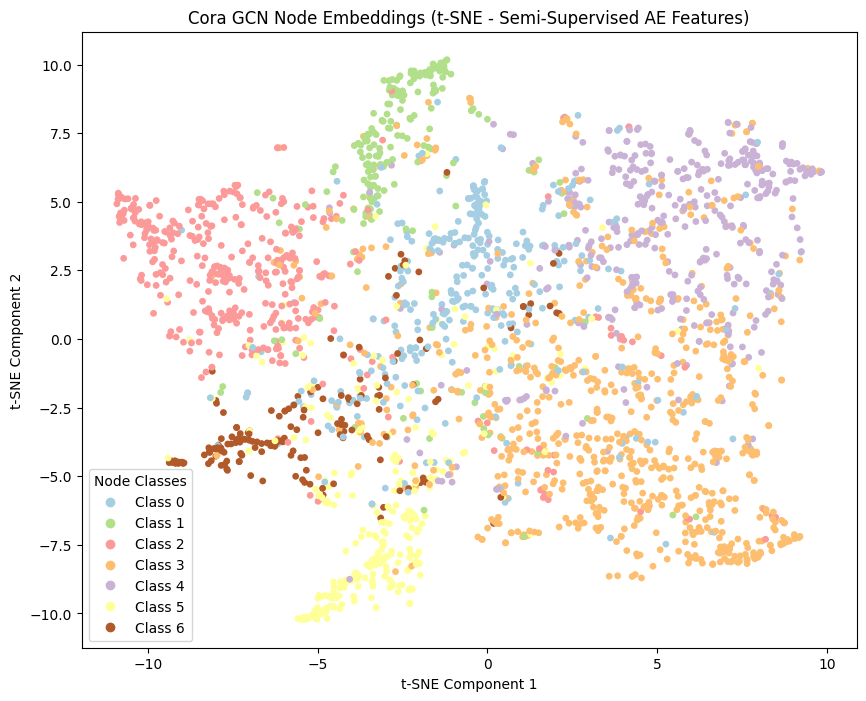


--- Starting t-SNE Visualization (Pure AE Features) ---
Embeddings shape: (2708, 16)
t-SNE fitting finished.


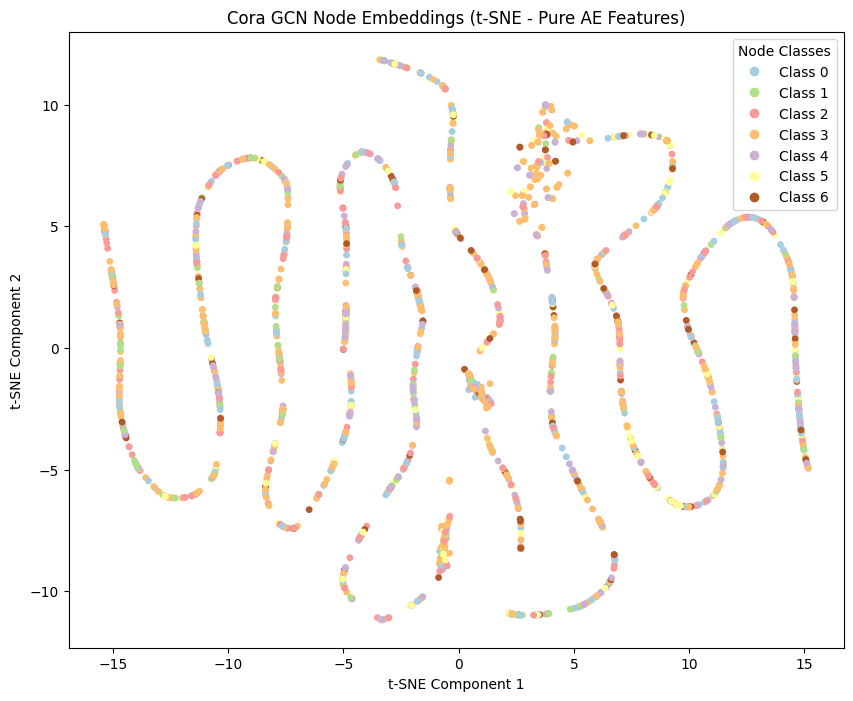


--- Starting t-SNE Visualization (Original Features) ---
Embeddings shape: (2708, 16)
t-SNE fitting finished.


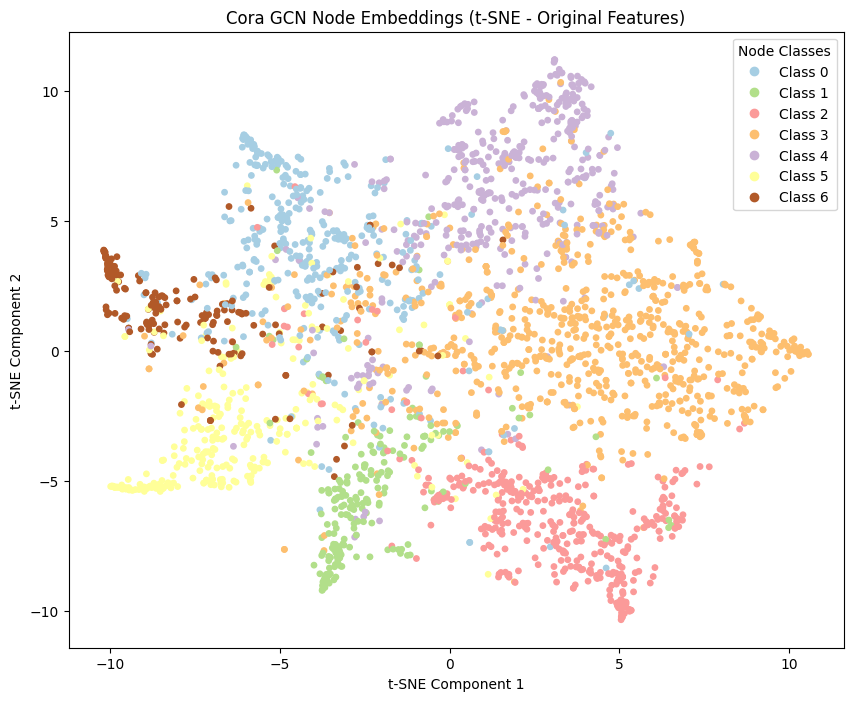

In [11]:
# block 11
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
from torch_geometric.datasets import Planetoid # Ensure Planetoid is imported

# --- New: Re-fetch dataset info before plotting ---
# This ensures dataset variable and num_classes are available
try:
    if 'dataset' not in locals(): # Check if dataset exists
        print("Reloading dataset info for legends...")
        # Only need to load once to get number of classes
        dataset = Planetoid(root='/home/xyx/gnn_demo/Cora', name='Cora') 
        print("Dataset info reloaded.")
    num_classes = dataset.num_classes # Get number of classes (should be 7)
except Exception as e:
    print(f"Warning: Could not reload dataset info for legend: {e}")
    num_classes = None # If loading fails, legend cannot be displayed
# --- End new ---


# --- 1. Plot Accuracy Curves (3-way comparison) ---
plt.figure(figsize=(12, 8))

# Check if accuracy lists are populated
lists_populated = True
if 'epochs' not in locals() or not epochs or not train_accs or not val_accs:
     print("Error: Accuracy data for Semi-Supervised AE model not found. Please re-run Block 5.")
     lists_populated = False
if 'epochs_pure' not in locals() or not epochs_pure or not train_accs_pure or not val_accs_pure:
     print("Error: Accuracy data for Pure AE model not found. Please re-run Block 8.")
     lists_populated = False
# --- New check ---
if 'epochs_orig' not in locals() or not epochs_orig or not train_accs_orig or not val_accs_orig:
     print("Error: Accuracy data for Original Features model not found. Please re-run Block 10.")
     lists_populated = False
# --- End new check ---

# Only plot if all data exists
if lists_populated:
    # --- Plot Semi-Supervised AE GCN (blue) ---
    plt.plot(epochs, train_accs, label='Train Acc (Semi-Supervised AE)', color='blue', linestyle='--')
    plt.plot(epochs, val_accs, label='Validation Acc (Semi-Supervised AE)', color='blue', linestyle='-')

    # --- Plot Pure AE GCN (orange) ---
    plt.plot(epochs_pure, train_accs_pure, label='Train Acc (Pure AE)', color='orange', linestyle='--')
    plt.plot(epochs_pure, val_accs_pure, label='Validation Acc (Pure AE)', color='orange', linestyle='-')

    # --- New: Plot Original Features GCN (green) ---
    plt.plot(epochs_orig, train_accs_orig, label='Train Acc (Original Features)', color='green', linestyle='--')
    plt.plot(epochs_orig, val_accs_orig, label='Validation Acc (Original Features)', color='green', linestyle='-')
    # --- End new ---

    # Add chart elements (English labels)
    plt.title('GCN Training and Validation Accuracy Comparison (3 Feature Types)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend() 
    plt.grid(True)
    plt.ylim(0, 1.0) 
    plt.show() # Show accuracy plot
else:
    print("Accuracy plotting skipped due to missing accuracy data.")


# --- 2. Define t-SNE visualization function (restore legend) ---
@torch.no_grad()
# --- Restore num_classes parameter ---
def visualize_tsne(model, data_obj, title_suffix, num_classes):
# --- End restore ---
    """ Helper function to generate t-SNE visualization of GCN embeddings (with legend) """
    print(f"\n--- Starting t-SNE Visualization ({title_suffix}) ---")
    model.eval()
    
    out = model(data_obj.x, data_obj.edge_index)
    
    if hasattr(model, 'embedding') and model.embedding is not None:
        h = model.embedding.detach().cpu().numpy()
        y_true = data_obj.y.cpu().numpy()
        print(f"Embeddings shape: {h.shape}") 

        tsne = TSNE(n_components=2, perplexity=30, max_iter=300, random_state=42) 
        h_2d = tsne.fit_transform(h)
        print("t-SNE fitting finished.")

        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(h_2d[:, 0], h_2d[:, 1], c=y_true, cmap='Paired', s=15)
        
        # --- Restore legend ---
        if num_classes is not None:
            plt.legend(handles=scatter.legend_elements()[0], 
                       labels=[f'Class {i}' for i in range(num_classes)],
                       title="Node Classes")
        else:
             print("Warning: Number of classes not available, skipping legend labels.")
        # --- End restore ---

        plt.title(f"Cora GCN Node Embeddings (t-SNE - {title_suffix})")
        plt.xlabel("t-SNE Component 1")
        plt.ylabel("t-SNE Component 2")
        plt.show() # Show t-SNE plot
    else:
        print(f"Error: Model ({title_suffix}) does not have 'embedding' attribute or it is None.")


# --- 3. Call visualization function (three groups) ---
# --- Pass num_classes ---
if 'gcn_model' in locals() and 'data' in locals():
     visualize_tsne(gcn_model, data, "Semi-Supervised AE Features", num_classes) 
else:
     print("\nSkipping t-SNE for Semi-Supervised AE: Model or data not found.")

if 'gcn_model_pure' in locals() and 'data_pure' in locals():
     visualize_tsne(gcn_model_pure, data_pure, "Pure AE Features", num_classes) 
else:
     print("\nSkipping t-SNE for Pure AE: Model or data not found.")

# --- New call ---
if 'gcn_model_orig' in locals() and 'data_orig' in locals():
     visualize_tsne(gcn_model_orig, data_orig, "Original Features", num_classes) 
else:
     print("\nSkipping t-SNE for Original Features: Model or data not found.")
# --- End new call ---

In [12]:
# block 12: Extract Embeddings and Prepare Data for Link Prediction (Cora)
import torch
import torch_geometric.utils as utils 
from torch_geometric.data import Data
import copy 
import warnings 

# Ignore deprecation warning
warnings.filterwarnings("ignore", ".*'train_test_split_edges' is deprecated.*")

print("\n--- [Link Prediction Cora] Block 10: Preparing Data ---")
print("Using 'utils.train_test_split_edges' + Manual 'utils.negative_sampling'.")

# 1a. Extract node embeddings from the trained GCN (gcn_model - Semi-supervised AE version)
gcn_model.eval() # Ensure the model is in evaluation mode
with torch.no_grad():
    # Run one forward pass to populate gcn_model.embedding
    _ = gcn_model(data.x, data.edge_index) 
    # Get embeddings (conv1 output, 16-dim) and detach from computation graph
    node_embeddings_cora = gcn_model.embedding.detach() 

print(f"Using node embeddings of shape: {node_embeddings_cora.shape}") # Should be [2708, 16]

# 1b. Create a temporary Data object (operate on CPU, as required by train_test_split_edges)
# Note: We use the edge_index from the 'data' object, which contains the full graph structure
link_pred_data_cpu_cora = Data(x=node_embeddings_cora.cpu(), 
                               edge_index=data.edge_index.cpu())

# --- Save a copy of edge_index (Important!) ---
original_edges_cpu_cora = link_pred_data_cpu_cora.edge_index.clone()
print(f"Saved original edges shape: {original_edges_cpu_cora.shape}")
# --- End saving ---

# 1c. Split using train_test_split_edges (without neg_sampling_ratio)
# This will remove link_pred_data_cpu_cora.edge_index
split_data_cora = utils.train_test_split_edges(
    link_pred_data_cpu_cora, 
    val_ratio=0.1, 
    test_ratio=0.1 # Use 10% validation set, 10% test set
)

# 1d. Manually add training negative samples
print("Manually sampling training negative edges...")
num_nodes_cora = link_pred_data_cpu_cora.num_nodes
num_train_pos_cora = split_data_cora.train_pos_edge_index.shape[1]

train_neg_edge_index_cora = utils.negative_sampling(
    edge_index=original_edges_cpu_cora, # Use the saved copy
    num_nodes=num_nodes_cora,
    num_neg_samples=num_train_pos_cora, # 1:1 negative sampling ratio
    method='sparse'
)
# Add manually sampled negative edges to the data object
split_data_cora.train_neg_edge_index = train_neg_edge_index_cora

# 1e. Move this data object containing all splits to the device
split_data_cora = split_data_cora.to(device)

# 1f. Verify that all required attributes now exist
print("Data splitting complete.")
print(f"Training pos links: {split_data_cora.train_pos_edge_index.shape[1]}")
print(f"Training neg links: {split_data_cora.train_neg_edge_index.shape[1]} (Manually Added)")
print(f"Validation pos links: {split_data_cora.val_pos_edge_index.shape[1]}")
print(f"Validation neg links: {split_data_cora.val_neg_edge_index.shape[1]}")
print(f"Test pos links: {split_data_cora.test_pos_edge_index.shape[1]}")
print(f"Test neg links: {split_data_cora.test_neg_edge_index.shape[1]}")

# 1g. Ensure the node_embeddings_cora variable is on the device for later use
node_embeddings_cora = node_embeddings_cora.to(device)
print(f"Node embeddings for Cora are on device: {node_embeddings_cora.device}")


--- [Link Prediction Cora] Block 10: Preparing Data ---
Using 'utils.train_test_split_edges' + Manual 'utils.negative_sampling'.
Using node embeddings of shape: torch.Size([2708, 16])
Saved original edges shape: torch.Size([2, 10556])
Manually sampling training negative edges...
Data splitting complete.
Training pos links: 8448
Training neg links: 8448 (Manually Added)
Validation pos links: 527
Validation neg links: 527
Test pos links: 527
Test neg links: 527
Node embeddings for Cora are on device: cuda:7


In [13]:
# block 13: Define Link Predictor MLP (Cora)
import torch

# This class is identical to the one in the PubMed task, just instantiated with a different embedding_dim
class LinkPredictor(torch.nn.Module):
    def __init__(self, embedding_dim, hidden_dim=64):
        super().__init__()
        # MLP receives two concatenated embeddings
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(embedding_dim * 2, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 1) # Output a single logit
        )

    def forward(self, all_node_embeddings, edge_label_index):
        # 1. Get embeddings for source and target nodes from edge indices
        source_emb = all_node_embeddings[edge_label_index[0]]
        target_emb = all_node_embeddings[edge_label_index[1]]
        
        # 2. Concatenate them
        x = torch.cat([source_emb, target_emb], dim=1)
        
        # 3. Pass through the MLP
        x = self.mlp(x)
        
        # 4. Return raw logits (BCEWithLogitsLoss needs this)
        return x.squeeze(-1)

print("LinkPredictor class defined.")

LinkPredictor class defined.


In [14]:
# block 14: Initialize MLP, Optimizer, Loss (Cora)
import torch.optim as optim

device = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')

# 1. Instantiate model (using _cora suffix)
# node_embeddings_cora was created in Block 12 (16-dim)
embedding_dim_cora = node_embeddings_cora.shape[1]
link_predictor_cora = LinkPredictor(embedding_dim=embedding_dim_cora).to(device)

# 2. Define optimizer (using _cora suffix)
optimizer_link_cora = optim.Adam(link_predictor_cora.parameters(), lr=0.001)

# 3. Define loss function (using _cora suffix)
criterion_link_cora = torch.nn.BCEWithLogitsLoss()

print(f"\nLinkPredictor model for Cora instantiated on {device}.")
print(link_predictor_cora)
print(f"Input embedding dimension: {embedding_dim_cora}")


LinkPredictor model for Cora instantiated on cuda:7.
LinkPredictor(
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)
Input embedding dimension: 16


In [ ]:
# block 15: Define Training and Testing Functions for Link Prediction (Cora)
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score # Ensure roc_auc_score is imported

def train_link_pred_cora():
    link_predictor_cora.train()
    optimizer_link_cora.zero_grad()
    
    # 1. Combine positive and negative edges from the training set
    pos_edges = split_data_cora.train_pos_edge_index
    neg_edges = split_data_cora.train_neg_edge_index
    train_edges = torch.cat([pos_edges, neg_edges], dim=1)
    
    # 2. Create corresponding labels (1 for pos, 0 for neg)
    pos_labels = torch.ones(pos_edges.shape[1], device=device)
    neg_labels = torch.zeros(neg_edges.shape[1], device=device)
    train_labels = torch.cat([pos_labels, neg_labels])
    
    # 3. Forward pass
    logits = link_predictor_cora(node_embeddings_cora, train_edges)
    
    # 4. Calculate loss
    loss = criterion_link_cora(logits, train_labels)
    
    loss.backward()
    optimizer_link_cora.step()
    return loss.item()

@torch.no_grad()
def test_link_pred_cora(pos_edge_index, neg_edge_index):
    link_predictor_cora.eval()
    
    # 1. Get logits for positive and negative samples separately
    pos_logits = link_predictor_cora(node_embeddings_cora, pos_edge_index)
    neg_logits = link_predictor_cora(node_embeddings_cora, neg_edge_index)
    
    # 2. Combine logits and calculate probabilities
    logits = torch.cat([pos_logits, neg_logits])
    probs = logits.sigmoid()
    
    # 3. Create corresponding labels
    pos_labels = torch.ones(pos_logits.shape[0])
    neg_labels = torch.zeros(neg_logits.shape[0])
    labels = torch.cat([pos_labels, neg_labels])
    
    # 4. Calculate AUC (Sklearn requires CPU numpy)
    labels_cpu = labels.cpu().numpy()
    probs_cpu = probs.cpu().numpy()
    
    return roc_auc_score(labels_cpu, probs_cpu)

print("Training and testing functions for Cora link prediction are defined.")

Training and testing functions for Cora link prediction are defined.


In [16]:
# block 16: Training Loop for Link Predictor (Cora)
import copy # Ensure copy is imported

# New variables with _cora suffix
best_val_auc_cora = 0.0
best_model_state_link_cora = None
num_epochs_link_cora = 100 # Can be increased if needed

print("\n--- Starting Cora Link Predictor Training ---")
for epoch in range(1, num_epochs_link_cora + 1):
    loss_cora = train_link_pred_cora()
    
    # Evaluate on the validation set
    val_auc_cora = test_link_pred_cora(split_data_cora.val_pos_edge_index, 
                                       split_data_cora.val_neg_edge_index)
    
    # Early stopping logic: save the model with the highest validation AUC
    if val_auc_cora > best_val_auc_cora:
        best_val_auc_cora = val_auc_cora
        best_model_state_link_cora = copy.deepcopy(link_predictor_cora.state_dict())
        
    if epoch % 10 == 0:
        # Also test on training set (optional)
        train_auc_cora = test_link_pred_cora(split_data_cora.train_pos_edge_index,
                                             split_data_cora.train_neg_edge_index)
        print(f'Epoch: {epoch:03d}, Loss: {loss_cora:.4f}, '
              f'Train AUC: {train_auc_cora:.4f}, Val AUC: {val_auc_cora:.4f}')

print("--- Cora Link Predictor Training Finished ---")
print(f"Best Validation AUC achieved: {best_val_auc_cora:.4f}")


--- Starting Cora Link Predictor Training ---
Epoch: 010, Loss: 0.6786, Train AUC: 0.6730, Val AUC: 0.6752
Epoch: 020, Loss: 0.6621, Train AUC: 0.7255, Val AUC: 0.7404
Epoch: 030, Loss: 0.6461, Train AUC: 0.7813, Val AUC: 0.8021
Epoch: 040, Loss: 0.6275, Train AUC: 0.8381, Val AUC: 0.8579
Epoch: 050, Loss: 0.6059, Train AUC: 0.8694, Val AUC: 0.8873
Epoch: 060, Loss: 0.5810, Train AUC: 0.8855, Val AUC: 0.9015
Epoch: 070, Loss: 0.5537, Train AUC: 0.8954, Val AUC: 0.9107
Epoch: 080, Loss: 0.5252, Train AUC: 0.9016, Val AUC: 0.9162
Epoch: 090, Loss: 0.4976, Train AUC: 0.9057, Val AUC: 0.9202
Epoch: 100, Loss: 0.4723, Train AUC: 0.9086, Val AUC: 0.9230
--- Cora Link Predictor Training Finished ---
Best Validation AUC achieved: 0.9230


In [17]:
# block 17: Final Evaluation of Link Predictor (Cora)

print(f"\nLoading best Cora link predictor model with Val AUC: {best_val_auc_cora:.4f}")
if best_model_state_link_cora:
    link_predictor_cora.load_state_dict(best_model_state_link_cora)
else:
    print("Warning: No best model state was saved for Cora link predictor.")

# Run final evaluation on the test set
final_test_auc_cora = test_link_pred_cora(split_data_cora.test_pos_edge_index, 
                                        split_data_cora.test_neg_edge_index)

print("\n--- Final Cora Link Prediction Evaluation (Best Model) ---")
print(f'Final Test AUC: {final_test_auc_cora:.4f}')


Loading best Cora link predictor model with Val AUC: 0.9230

--- Final Cora Link Prediction Evaluation (Best Model) ---
Final Test AUC: 0.9139



--- [Link Prediction Cora] Block 18: Visualizing Test Set ROC Curve ---


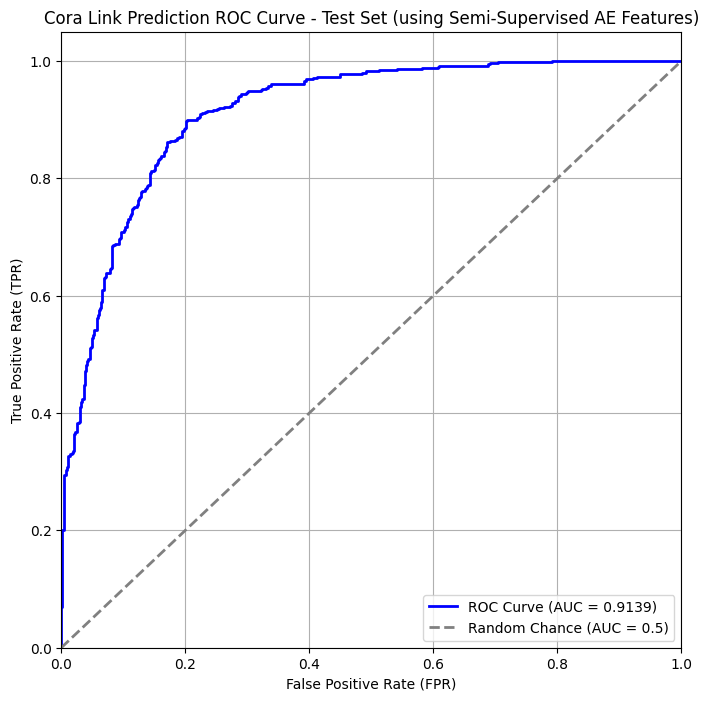

In [18]:
# block 18: Visualize ROC Curve for Link Predictor (Cora)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve # Ensure roc_curve is imported

print("\n--- [Link Prediction Cora] Block 18: Visualizing Test Set ROC Curve ---")

# 1. Ensure the model is in evaluation mode
link_predictor_cora.eval()

with torch.no_grad():
    # 2. Get logits for test set positive and negative samples
    pos_logits = link_predictor_cora(node_embeddings_cora, split_data_cora.test_pos_edge_index)
    neg_logits = link_predictor_cora(node_embeddings_cora, split_data_cora.test_neg_edge_index)

    # 3. Combine logits and labels
    logits = torch.cat([pos_logits, neg_logits])
    probs = logits.sigmoid() # Probabilities
    
    pos_labels = torch.ones(pos_logits.shape[0])
    neg_labels = torch.zeros(neg_logits.shape[0])
    labels = torch.cat([pos_labels, neg_labels])
    
    # 4. Move to CPU/Numpy
    labels_cpu = labels.cpu().numpy()
    probs_cpu = probs.cpu().numpy()

# 5. Calculate points for ROC curve
fpr, tpr, thresholds = roc_curve(labels_cpu, probs_cpu)

# 6. Plot using Matplotlib
plt.figure(figsize=(8, 8))
# (final_test_auc_cora was calculated in Block 17)
plt.plot(fpr, tpr, color='blue', lw=2, 
         label=f'ROC Curve (AUC = {final_test_auc_cora:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Chance (AUC = 0.5)')

# 7. Add labels and title (English)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Cora Link Prediction ROC Curve - Test Set (using Semi-Supervised AE Features)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [20]:
# block 19: Find 5 Most Similar Same-Class and Diff-Class Nodes
import torch
import torch.nn.functional as F

print("\n--- [Node Similarity] Block 19: Finding Similar Nodes ---")

# --- Parameters ---
target_node_id = 28  # Example: Choose node 0. You can change this ID.
k = 5

# Use embeddings from the Semi-Supervised AE GCN (from Block 12)
embeddings_to_use = node_embeddings_cora 
# Use labels from the main 'data' object (from Block 3)
labels_to_use = data.y
# --- End Parameters ---

try:
    # 1. Get info for the target node
    target_emb = embeddings_to_use[target_node_id].unsqueeze(0) # Shape [1, 16]
    target_label = labels_to_use[target_node_id].item()

    print(f"Target Node ID: {target_node_id}")
    print(f"Target Node Label: {target_label}")

    # 2. Calculate cosine similarity against all nodes
    # embeddings_to_use shape is [N, 16], target_emb is [1, 16]
    all_similarities = F.cosine_similarity(target_emb, embeddings_to_use, dim=1)

    # 3. Create masks for same/different classes, excluding the target node itself
    all_indices = torch.arange(labels_to_use.shape[0], device=device)
    same_class_mask = (labels_to_use == target_label)
    diff_class_mask = (labels_to_use != target_label)
    
    # Exclude the target node itself from the "same class" group
    same_class_mask[target_node_id] = False 

    same_class_indices = all_indices[same_class_mask]
    diff_class_indices = all_indices[diff_class_mask]

    # 4. Find top k for SAME class
    same_class_sims = all_similarities[same_class_indices]
    top_k_same_sims, top_k_local_indices_same = torch.topk(same_class_sims, k=k, largest=True)
    top_k_same_class_nodes = same_class_indices[top_k_local_indices_same]

    # 5. Find top k for DIFFERENT class
    diff_class_sims = all_similarities[diff_class_indices]
    top_k_diff_sims, top_k_local_indices_diff = torch.topk(diff_class_sims, k=k, largest=True)
    top_k_diff_class_nodes = diff_class_indices[top_k_local_indices_diff]
    top_k_diff_class_labels = labels_to_use[top_k_diff_class_nodes]

    # 6. Print results
    print(f"\n--- Top {k} Most Similar SAME-Class Nodes (Label {target_label}) ---")
    for i in range(k):
        node_id = top_k_same_class_nodes[i].item()
        sim = top_k_same_sims[i].item()
        print(f"  Rank {i+1}: Node ID {node_id}, Similarity: {sim:.4f}")

    print(f"\n--- Top {k} Most Similar DIFFERENT-Class Nodes ---")
    for i in range(k):
        node_id = top_k_diff_class_nodes[i].item()
        label = top_k_diff_class_labels[i].item()
        sim = top_k_diff_sims[i].item()
        print(f"  Rank {i+1}: Node ID {node_id}, Label: {label}, Similarity: {sim:.4f}")

except NameError as e:
    print(f"Error: Required variables (like 'node_embeddings_cora' or 'data') not found.")
    print("Please ensure Blocks 3, 4, 5, and 12 have been run.")
except Exception as e:
    print(f"An error occurred: {e}")


--- [Node Similarity] Block 19: Finding Similar Nodes ---
Target Node ID: 28
Target Node Label: 2

--- Top 5 Most Similar SAME-Class Nodes (Label 2) ---
  Rank 1: Node ID 1114, Similarity: 0.9992
  Rank 2: Node ID 328, Similarity: 0.9985
  Rank 3: Node ID 1717, Similarity: 0.9985
  Rank 4: Node ID 883, Similarity: 0.9977
  Rank 5: Node ID 534, Similarity: 0.9977

--- Top 5 Most Similar DIFFERENT-Class Nodes ---
  Rank 1: Node ID 260, Label: 0, Similarity: 0.9811
  Rank 2: Node ID 768, Label: 3, Similarity: 0.9785
  Rank 3: Node ID 750, Label: 5, Similarity: 0.9611
  Rank 4: Node ID 2058, Label: 5, Similarity: 0.9403
  Rank 5: Node ID 2470, Label: 0, Similarity: 0.9146


In [2]:
!nvidia-smi

Thu Oct 30 06:40:08 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          On  | 00000000:01:00.0 Off |                    0 |
| N/A   43C    P0              79W / 300W |  40368MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--